In [1]:
# 导入相关包 
import os
import random
import numpy as np

from Maze import Maze
from QRobot import QRobot
from ReplayDataSet import ReplayDataSet
from torch_py.QNetwork import QNetwork
from Runner import Runner

import matplotlib.pyplot as plt

import numpy as np
import random

import torch
import torch.nn.functional as F
from torch import optim


os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复载入lib文件

c:\Users\dell\anaconda3\envs\AI2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Robot(QRobot):
    valid_action = ['u', 'r', 'd', 'l']

    ''' QLearning parameters'''
    epsilon0 = 0.5  # 初始贪心算法探索概率
    gamma = 0.94  # 公式中的 γ

    EveryUpdate = 32  # the interval of target model's updating

    """some parameters of neural network"""
    target_model = None
    eval_model = None
    batch_size = 32
    learning_rate = 1e-2
    TAU = 1e-3
    step = 1  # 记录训练的步数

    """setting the device to train network"""
    # device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    device = torch.device("cpu")

    def __init__(self, maze):
        """
        初始化 Robot 类
        :param maze:迷宫对象
        """
        super(Robot, self).__init__(maze)
        maze.set_reward(reward={
            "hit_wall": 100.,
            "destination": -500.,
            "default": -1.,
        })
        self.maze = maze
        self.maze_size = maze.maze_size

        """build network"""
        self.target_model = None
        self.eval_model = None
        self._build_network()

        """create the memory to store data"""
        max_size = max(self.maze_size ** 2 * 3, 1e4)
        self.memory = ReplayDataSet(max_size=max_size)

        # self.memory.build_full_view(maze=maze)

        """parameters"""
        self.gamma = 0.74
        self.epsilon0 = 0.8
        self.visited = []
        self.loss = 0
        self.q_table = {}
        self.prev_state = None
        self.mod = 'train' # 'train' or 'explore'

    def _build_network(self):
        seed = 0
        random.seed(seed)

        """build target model"""
        self.target_model = QNetwork(state_size=2, action_size=4, seed=seed).to(self.device)

        """build eval model"""
        self.eval_model = QNetwork(state_size=2, action_size=4, seed=seed).to(self.device)

        """build the optimizer"""
        self.optimizer = optim.Adam(self.eval_model.parameters(), lr=self.learning_rate)
        # self.optimizer = optim.SGD(self.eval_model.parameters(), lr=self.learning_rate)

    def target_replace_op(self):
        """
            Soft update the target model parameters.
            θ_target = τ*θ_local + (1 - τ)*θ_target
        """

        # for target_param, eval_param in zip(self.target_model.parameters(), self.eval_model.parameters()):
        #     target_param.data.copy_(self.TAU * eval_param.data + (1.0 - self.TAU) * target_param.data)

        """ replace the whole parameters"""
        self.target_model.load_state_dict(self.eval_model.state_dict())

    def _choose_action(self, state):
        if self.mod == 'train':
            state = np.array(state)
            state = torch.from_numpy(state).float().to(self.device)
            if random.random() < self.epsilon:
                action = random.choice(self.valid_action)
            else:
                self.eval_model.eval()
                with torch.no_grad():
                    q_next = self.eval_model(state).cpu().data.numpy()  # use target model choose action
                self.eval_model.train()

                action = self.valid_action[np.argmin(q_next).item()]
        
        elif self.mod == 'explore':
            action = random.choice(self.valid_action)

        return action

    def _learn(self, batch: int = 16):
        if len(self.memory) < batch:
            # print("the memory data is not enough")
            batch = len(self.memory)

        state, action_index, reward, next_state, is_terminal = self.memory.random_sample(batch)

        """ convert the data to tensor type"""
        state = torch.from_numpy(state).float().to(self.device)
        action_index = torch.from_numpy(action_index).long().to(self.device)
        reward = torch.from_numpy(reward).float().to(self.device)
        next_state = torch.from_numpy(next_state).float().to(self.device)
        is_terminal = torch.from_numpy(is_terminal).int().to(self.device)

        self.eval_model.train()
        self.target_model.eval()

        """Get max predicted Q values (for next states) from target model"""
        Q_targets_next = self.target_model(next_state).detach().min(1)[0].unsqueeze(1)

        """Compute Q targets for current states"""
        Q_targets = reward + self.gamma * Q_targets_next * (torch.ones_like(is_terminal) - is_terminal)

        """Get expected Q values from local model"""
        self.optimizer.zero_grad()
        Q_expected = self.eval_model(state).gather(dim=1, index=action_index)

        """Compute loss"""
        loss = F.mse_loss(Q_expected, Q_targets)
        loss_item = loss.item()

        """ Minimize the loss"""
        loss.backward()
        self.optimizer.step()

        
        return loss_item

    def train_update(self):
        state = self.sense_state()
        action = self._choose_action(state)
        reward = self.maze.move_robot(action)
        next_state = self.sense_state()

        if next_state == self.maze.destination \
            or self.prev_state == next_state \
                or next_state == state:
            is_terminal = 1
        else:
            is_terminal = 0

        self.prev_state = state
        
        if self.mod == 'explore':
            self.memory.add(state, self.valid_action.index(action), reward, next_state, is_terminal)

        """--间隔一段时间更新target network权重--"""
        
        if self.mod == 'train':
            batch = 32
            # batch = len(self.memory)
            self._learn(batch)

            """copy the weights of eval_model to the target_model"""
            if self.step % self.EveryUpdate == 0:
                self.target_replace_op()


        """---update the step and epsilon---"""
        self.step += 1
        self.epsilon = max(0.1, self.epsilon * 0.995)

        return action, reward

    def test_update(self):
        state = np.array(self.sense_state(), dtype=np.int16)
        state = torch.from_numpy(state).float().to(self.device)

        self.eval_model.eval()
        with torch.no_grad():
            q_value = self.eval_model(state).cpu().data.numpy()

        action = self.valid_action[np.argmin(q_value).item()]
        reward = self.maze.move_robot(action)
        return action, reward

    def show_Q(self, print_flag=False):
        for i in range(self.maze.maze_size):
            for j in range(self.maze.maze_size):

                state = np.array([i, j], dtype=np.int16)
                state = torch.from_numpy(state).float().to(self.device)

                self.eval_model.eval()
                with torch.no_grad():
                    q_value = self.eval_model(state).cpu().data.numpy()

                action = self.valid_action[np.argmin(q_value).item()]

                self.q_table[(j, i)] = q_value
                if print_flag: print(i, j, action, q_value)
    
    def train_with_full_view(self, train_epoch):
        self.step = 0
        batch_size = len(self.memory)

        for i in range(train_epoch):
            loss = self._learn(batch_size)
            print('loss:', loss)

            """copy the weights of eval_model to the target_model"""
            if self.step % self.EveryUpdate == 0:
                self.target_replace_op()

            self.step += 1


In [3]:
"""  Deep Qlearning 算法相关参数： """

maze_size = 7  # 迷宫size


""" 使用 DQN 算法训练 """

g = Maze(maze_size=maze_size)
r = Robot(g)
runner = Runner(r)

epoch: 0, success: False, robot mod: explore
epoch: 1, success: False, robot mod: explore
epoch: 2, success: False, robot mod: explore
epoch: 3, success: False, robot mod: explore
epoch: 4, success: False, robot mod: explore
epoch: 5, success: False, robot mod: explore
epoch: 6, success: False, robot mod: explore
epoch: 7, success: False, robot mod: explore
epoch: 8, success: False, robot mod: explore
epoch: 9, success: False, robot mod: explore
epoch: 10, success: False, robot mod: explore
epoch: 11, success: False, robot mod: explore
epoch: 12, success: False, robot mod: explore
epoch: 13, success: False, robot mod: explore
epoch: 14, success: False, robot mod: explore
epoch: 15, success: False, robot mod: explore
epoch: 16, success: False, robot mod: explore
epoch: 17, success: False, robot mod: explore
epoch: 18, success: False, robot mod: explore
epoch: 19, success: False, robot mod: explore
epoch: 20, success: False, robot mod: explore
epoch: 21, success: False, robot mod: explor

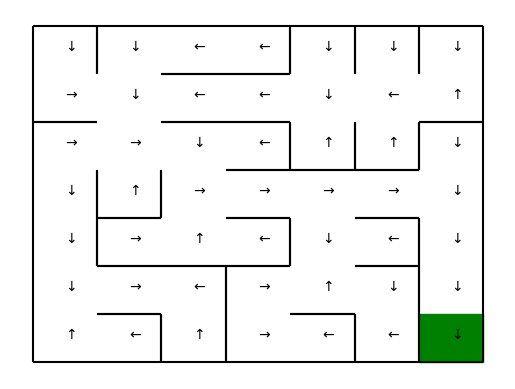

In [4]:
training_per_epoch = int(maze_size * maze_size * 1.5)
testing_per_epoch = int(maze_size * maze_size * 0.8)

flag = runner.train_and_test(training_per_epoch, testing_per_epoch)

r.show_Q(print_flag=False)

g.show_dir(r.q_table)

In [7]:
r.memory.Experience

{((0, 0),
  3): Row(state=[0, 0], action_index=3, reward=100.0, next_state=[0, 0], is_terminal=1),
 ((0, 0),
  0): Row(state=[0, 0], action_index=0, reward=100.0, next_state=[0, 0], is_terminal=1),
 ((0, 0),
  2): Row(state=[0, 0], action_index=2, reward=-1.0, next_state=[1, 0], is_terminal=0),
 ((1, 0),
  3): Row(state=[1, 0], action_index=3, reward=100.0, next_state=[1, 0], is_terminal=1),
 ((1, 0),
  2): Row(state=[1, 0], action_index=2, reward=100.0, next_state=[1, 0], is_terminal=1),
 ((1, 0),
  1): Row(state=[1, 0], action_index=1, reward=-1.0, next_state=[1, 1], is_terminal=0),
 ((1, 1),
  1): Row(state=[1, 1], action_index=1, reward=-1.0, next_state=[1, 2], is_terminal=0),
 ((1, 2),
  2): Row(state=[1, 2], action_index=2, reward=100.0, next_state=[1, 2], is_terminal=1),
 ((1, 2),
  1): Row(state=[1, 2], action_index=1, reward=-1.0, next_state=[1, 3], is_terminal=0),
 ((1, 3),
  0): Row(state=[1, 3], action_index=0, reward=100.0, next_state=[1, 3], is_terminal=1),
 ((1, 3),
  2)